In [2]:
import mne
import numpy as np

In [3]:
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne.datasets import sample
from mne.decoding import cross_val_multiscore, LinearModel, GeneralizingEstimator, Scaler, \
                         Vectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, StratifiedShuffleSplit, \
                                    RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

In [4]:
SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/'
filename_epoch = SAVE_EPOCH_ROOT +  'epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif'

#Read Epochs
epochs_orig = mne.read_epochs(filename_epoch, proj=True, preload=True, verbose=None)
epochs = epochs_orig.copy()
subset = epochs['pred']['non'].copy()
subset = subset.pick_types(eeg=True)
subset.crop(tmin=-0.45,tmax=0.45)

Reading ../../data/version5.2/preprocessed/epochs/aft_ICA_rej/epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 129) active
    Found the data of interest:
        t =    -400.00 ...    5000.00 ms
        0 CTF compensation matrices available
1197 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1197 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
Created an SSP operator (subspace dimension = 1)
1 projection items activated


<ipython-input-4-5428fbcee6a7>:9: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  subset.crop(tmin=-0.45,tmax=0.45)


<EpochsFIF  |   876 events (all good), -0.4 - 0.448 sec, baseline [-0.4, 0], ~183.9 MB, data loaded, with metadata,
 'pred/down/non': 216
 'pred/left/non': 224
 'pred/right/non': 219
 'pred/up/non': 217>

## Some preprocessing

In [7]:
if subset['Block==6'].metadata.Ptrn_Type.values.shape[0]>0:
       main_ptrn = subset['Block==6'].metadata.Ptrn_Type.values[0]
else:
       main_ptrn = subset['Block==8'].metadata.Ptrn_Type.values[0]

# only early blocks
subset = subset['Block<7'].copy()
subset = subset['Block>2'].copy()

# Group data based on the previous trial
Grp1 = subset['Trgt_Loc_prev==1'].copy()
Grp2 = subset['Trgt_Loc_prev==2'].copy()
Grp3 = subset['Trgt_Loc_prev==3'].copy()
Grp4 = subset['Trgt_Loc_prev==4'].copy()

Grp1._data = (Grp1._data - np.mean(Grp1._data)) / np.std(Grp1._data)
Grp2._data = (Grp2._data - np.mean(Grp2._data)) / np.std(Grp2._data)
Grp3._data = (Grp3._data - np.mean(Grp3._data)) / np.std(Grp3._data)
Grp4._data = (Grp4._data - np.mean(Grp4._data)) / np.std(Grp4._data)

# Autocorrelation

In [8]:
# https://stackoverflow.com/questions/30143417/computing-the-correlation-coefficient-between-two-multi-dimensional-arrays
def generate_correlation_map(x, y):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    if n != y.shape[1]:
        raise ValueError('x and y must ' +
                         'have the same number of timepoints.')
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])

352 129 213


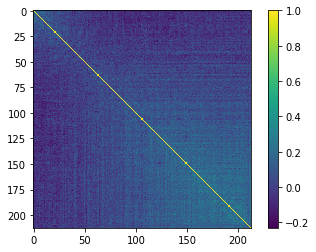

In [63]:
trialInd = subset._data.shape[0]
chanInd  = subset._data.shape[1]
timeInd  = subset._data.shape[2]
print(trialInd, chanInd, timeInd)

dt = np.mean(subset._data, axis=1) #avg over channels
x1 = np.transpose(dt)
map_r = generate_correlation_map(x1, x1)
plt.imshow(map_r)
plt.colorbar()
     

In [64]:
map_r

array([[ 1.        ,  0.25533999,  0.13578316, ...,  0.01015997,
        -0.09168387, -0.06847411],
       [ 0.25533999,  1.        ,  0.19583798, ..., -0.02793118,
        -0.0861775 , -0.11443345],
       [ 0.13578316,  0.19583798,  1.        , ..., -0.06345703,
        -0.05729772, -0.09079245],
       ...,
       [ 0.01015997, -0.02793118, -0.06345703, ...,  1.        ,
         0.18180659,  0.15449776],
       [-0.09168387, -0.0861775 , -0.05729772, ...,  0.18180659,
         1.        ,  0.20011019],
       [-0.06847411, -0.11443345, -0.09079245, ...,  0.15449776,
         0.20011019,  1.        ]])

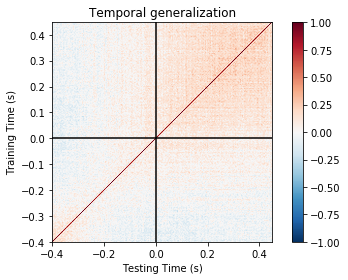

In [65]:
fig, ax = plt.subplots(1, 1)
plt.tight_layout()
im = ax.imshow(map_r, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=subset.times[[0, -1, 0 , -1]], vmin=-1, vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
ax.xaxis.set_ticks_position('bottom')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# Autocorrelation for each group

In [16]:
dt = np.mean(Grp1._data, axis=1) #avg over channels
x1 = np.transpose(dt)
map_G1 = generate_correlation_map(x1, x1)

dt = np.mean(Grp2._data, axis=1) #avg over channels
x1 = np.transpose(dt)
map_G2 = generate_correlation_map(x1, x1)

dt = np.mean(Grp2._data, axis=1) #avg over channels
x1 = np.transpose(dt)
map_G3 = generate_correlation_map(x1, x1)

dt = np.mean(Grp3._data, axis=1) #avg over channels
x1 = np.transpose(dt)
map_G4 = generate_correlation_map(x1, x1)

In [19]:
avg_map= np.zeros([4, map_G1.shape[0], map_G1.shape[1]])
avg_map[0,:,:] = map_G1
avg_map[1,:,:] = map_G2
avg_map[2,:,:] = map_G3
avg_map[3,:,:] = map_G4
avg_map = np.mean(avg_map, axis=0)
print(avg_map.shape)

(213, 213)


In [23]:
import pickle
fn_str = 'autocorr_res'
with open(fn_str, 'wb') as f:
    pickle.dump(avg_map, f)

In [27]:
fn_str = 'autocorr_res'
with open(fn_str, 'rb') as f:
    avg_map_l = pickle.load(f)

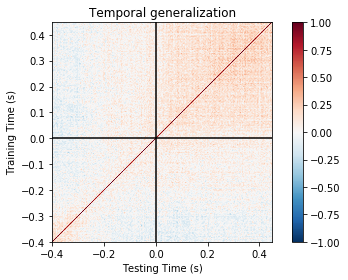

In [28]:
fig, ax = plt.subplots(1, 1)
plt.tight_layout()
im = ax.imshow(avg_map_l, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=subset.times[[0, -1, 0 , -1]], vmin=-1, vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
ax.xaxis.set_ticks_position('bottom')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

(2, 2)


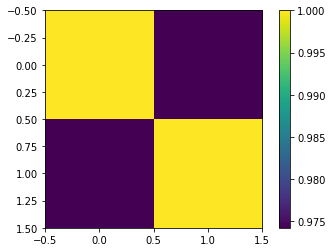

In [59]:
# x1 = np.random.rand(32,12)
# x2 = np.random.rand(32,12)
x1=np.asarray([[1,3,5,6],[2,5,6,7]])
x2=np.asarray([[3,5,6,2],[4,5,6,8]])

map_r = generate_correlation_map(x1, x1)
print(map_r.shape)
plt.imshow(map_r)
plt.colorbar()

